### Importing Necessary Libraries

In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAvgPool2D, BatchNormalization
# from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import precision_recall_fscore_support as score

## Data

A detailed discussion and visualization of the data can be seen in [here](Data-Overview.ipynb).

In [2]:
labels = pd.read_csv("./Data/train_labels.csv")
images = ['./Data/train/train/'+str(name)+'.tif' for name in labels['id']]
labels['images'] = images
labels = labels[['id', 'images', 'label']]

In [3]:
labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15995,15995,./Data/train/train/15995.tif,2
15996,15996,./Data/train/train/15996.tif,15
15997,15997,./Data/train/train/15997.tif,3
15998,15998,./Data/train/train/15998.tif,9


In [4]:
train_labels = pd.read_csv('./Data/train_labels_1.csv')
test_labels = pd.read_csv('./Data/test_labels_1.csv')

In [5]:
train_labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15195,15995,./Data/train/train/15995.tif,2
15196,15996,./Data/train/train/15996.tif,15
15197,15997,./Data/train/train/15997.tif,3
15198,15998,./Data/train/train/15998.tif,9


In [6]:
test_labels

,id,images,label
0,18,./Data/train/train/18.tif,11
1,25,./Data/train/train/25.tif,8
2,33,./Data/train/train/33.tif,6
3,41,./Data/train/train/41.tif,1
4,65,./Data/train/train/65.tif,14
...,...,...,...
795,15816,./Data/train/train/15816.tif,2
796,15824,./Data/train/train/15824.tif,2
797,15832,./Data/train/train/15832.tif,11
798,15863,./Data/train/train/15863.tif,15


In [7]:
class_labels = list(set(labels['label']))
class_names = [
    'letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific report', 'scientific publication',
    'specification', 'file folder', 'news article', 'budget', 'invoice', 'presentation', 'questionnaire', 'resume',
    'memo'
]
label_names = pd.DataFrame({
    'labels': class_labels,
    'names': class_names
})

## Data Preparation

We have already generated the Extracted Feature Vectors from the ResNet Model now we train using that, so we load those feature vectors.

In [8]:
fine_tune_data_resnet = np.load('./Data/ResNet-4P-train-precompute/whole_train_data_precomp.npy')
fine_tune_data_resnet.shape

(16000, 5, 2048)

In [9]:
N_COMPS_1 = 1300 # 1600
N_COMPS_2 = 300 # 400
N_COMPS_3 = 900 # 1000
random_state=43

In [10]:

pcas_resnet = [PCA(N_COMPS_1, random_state=random_state) for _ in range(5)]

In [11]:
for i in range(5):
    pcas_resnet[i].fit(fine_tune_data_resnet[:,i,:])

In [12]:
fine_tune_data_train_red_resnet = np.zeros((fine_tune_data_resnet.shape[0], 5, N_COMPS_1))
for i in range(5):
    fine_tune_data_train_red_resnet[:,i,:] = pcas_resnet[i].transform(fine_tune_data_resnet[:,i,:])
fine_tune_data_resnet = fine_tune_data_train_red_resnet
del fine_tune_data_train_red_resnet

In [13]:
fine_tune_data_resnet.shape

(16000, 5, 1300)

In [14]:
fine_tune_data_vgg = np.load('./Data/VGG16-4P-train-precompute/whole_train_data_precomp.npy')
fine_tune_data_vgg.shape

(16000, 5, 512)

In [15]:

pcas_vgg = [PCA(N_COMPS_2, random_state=random_state) for _ in range(5)]

In [16]:
for i in range(5):
    pcas_vgg[i].fit(fine_tune_data_vgg[:,i,:])

In [17]:
fine_tune_data_train_red_vgg = np.zeros((fine_tune_data_vgg.shape[0], 5, N_COMPS_2))
for i in range(5):
    fine_tune_data_train_red_vgg[:,i,:] = pcas_vgg[i].transform(fine_tune_data_vgg[:,i,:])
fine_tune_data_vgg = fine_tune_data_train_red_vgg
del fine_tune_data_train_red_vgg
fine_tune_data_vgg.shape

(16000, 5, 300)

In [18]:
fine_tune_data_inception_resnet = np.load('./Data/Inception-ResNet-4P-train-precompute/whole_train_data_precomp.npy')
fine_tune_data_inception_resnet.shape

(16000, 5, 1536)

In [19]:

pcas_inception_resnet = [PCA(N_COMPS_3, random_state=random_state) for _ in range(5)]

In [20]:
for i in range(5):
    pcas_inception_resnet[i].fit(fine_tune_data_inception_resnet[:,i,:])

In [21]:
fine_tune_data_train_red_inception_resnet = np.zeros((fine_tune_data_inception_resnet.shape[0], 5, N_COMPS_3))
for i in range(5):
    fine_tune_data_train_red_inception_resnet[:,i,:] = pcas_inception_resnet[i].transform(fine_tune_data_inception_resnet[:,i,:])
fine_tune_data_inception_resnet = fine_tune_data_train_red_inception_resnet
del fine_tune_data_train_red_inception_resnet
fine_tune_data_inception_resnet.shape

(16000, 5, 900)

In [22]:
fine_tune_data = np.concatenate([fine_tune_data_resnet, fine_tune_data_vgg, fine_tune_data_inception_resnet], axis=-1)
fine_tune_data.shape

(16000, 5, 2500)

In [23]:
fine_tune_labels = labels['label'].to_numpy()
fine_tune_labels.shape

(16000,)

In [24]:
# fine_tune_data_train = fine_tune_data[list(train_labels['id'])]
# fine_tune_data_train.shape

(15200, 5, 2500)

In [26]:
# np.save('./Data/ResNet-VGG-Inception-4Piece-PCA-train-precompute/whole_train_train_data_precomp.npy', fine_tune_data_train)

In [244]:
# fine_tune_labels_train = train_labels['label'].to_numpy()
# fine_tune_labels_train.shape

(15200,)

In [27]:
# fine_tune_data_test = fine_tune_data[list(test_labels['id'])]
# fine_tune_data_test.shape

(800, 5, 2500)

In [28]:
# np.save('./Data/ResNet-VGG-Inception-4Piece-PCA-train-precompute/whole_train_test_data_precomp.npy', fine_tune_data_test)

In [246]:
# fine_tune_labels_test = test_labels['label'].to_numpy()
# fine_tune_labels_test.shape

(800,)

## Fine-Tuning Models

The fine-tuning part of our model.

In [24]:
def ftmodel():
    inputs = Input(shape=(5, N_COMPS_1 + N_COMPS_2 + N_COMPS_3))
    x = Flatten()(inputs)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.5
    # x = Dropout(top_dropout_rate, name='top_dropout_1')(x)
    # x = Dense(1024, name='top_dense_1', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    # x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_2')(x)
    x = Dense(512, name='top_dense_2', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_3')(x)
    # x = Dense(256, name='top_dense_3', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    # x = BatchNormalization()(x)
    # x = Dropout(top_dropout_rate, name='top_dropout_4')(x)
    outputs = Dense(16, activation='softmax', name='pred', kernel_regularizer=l2(5e-5))(x)

    model1 = tf.keras.Model(inputs, outputs, name='RestNet-VGG-Inception-ResNet-FineTune')
    return model1

In [25]:
model1 = ftmodel()
model1.summary()

Metal device set to: Apple M1 Max


2022-10-09 18:21:19.399698: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-09 18:21:19.399882: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "RestNet-VGG-Inception-ResNet-FineTune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 2500)]         0         
                                                                 
 flatten (Flatten)           (None, 12500)             0         
                                                                 
 batch_normalization (BatchN  (None, 12500)            50000     
 ormalization)                                                   
                                                                 
 top_dropout_2 (Dropout)     (None, 12500)             0         
                                                                 
 top_dense_2 (Dense)         (None, 512)               6400512   
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)             

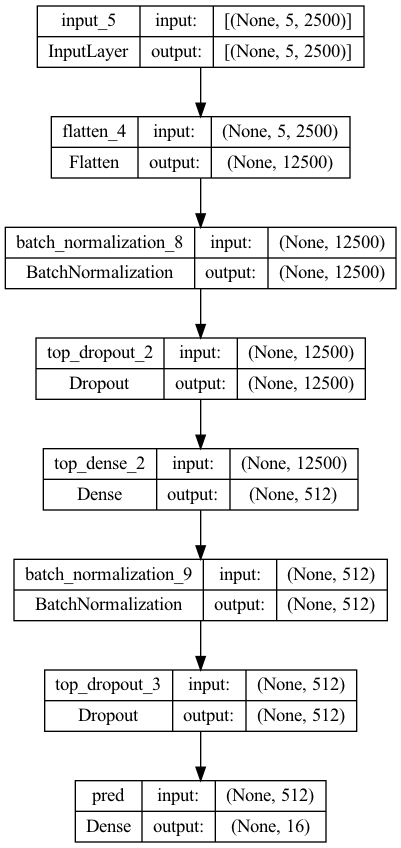

In [249]:
# tf.keras.utils.plot_model(model1, show_shapes=True, to_file='./Images/ResNet-VGG-Inception-ResNet-4Piece-PCA-Model.png')

### Model Training

The fine-tuning will be done on the ResNet+VGG+Inception-ResNet's PCA reduced $1024D+256D+768D$ representation vectors.

In [26]:
model1.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.0003))

In [27]:
EPOCHS = 1000
checkpoint_filepaths = ['./Models/ResNet-VGG-Inception-ResNet-4P/auto-ResNet-VGG-Inception-ResNet-FT-model-weight-full']
model_checkpoint_callback = [tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = "loss",
    mode='min',
    save_best_only=True) for checkpoint_filepath in checkpoint_filepaths]

In [29]:
history = model1.fit(fine_tune_data, fine_tune_labels, epochs=EPOCHS, batch_size=1600, callbacks=[model_checkpoint_callback])
model1.save_weights("./Models/ResNet-VGG-Inception-ResNet-4P/resnet-vgg-inception-resnet-4p-model-weights-full")
model1.load_weights('./Models/ResNet-VGG-Inception-ResNet-4P/resnet-vgg-inception-resnet-4p-model-weights-full')

Epoch 1/1000


2022-10-09 18:22:21.742009: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-09 18:22:22.010635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 5s 157ms/step - loss: 3.5321 - accuracy: 0.1604
Epoch 2/1000
10/10 [==============================] - 1s 52ms/step - loss: 2.0918 - accuracy: 0.4401
Epoch 3/1000
10/10 [==============================] - 1s 54ms/step - loss: 1.4305 - accuracy: 0.6099
Epoch 4/1000
10/10 [==============================] - 0s 49ms/step - loss: 1.0948 - accuracy: 0.6993
Epoch 5/1000
10/10 [==============================] - 0s 49ms/step - loss: 0.9070 - accuracy: 0.7478
Epoch 6/1000
10/10 [==============================] - 0s 49ms/step - loss: 0.7767 - accuracy: 0.7862
Epoch 7/1000
10/10 [==============================] - 0s 49ms/step - loss: 0.6580 - accuracy: 0.8173
Epoch 8/1000
10/10 [==============================] - 0s 49ms/step - loss: 0.5856 - accuracy: 0.8407
Epoch 9/1000
10/10 [==============================] - 0s 48ms/step - loss: 0.5223 - accuracy: 0.8601
Epoch 10/1000
10/10 [==============================] - 0s 48ms/step - loss: 0.4646 - accuracy: 0.8783
E

10/10 [==============================] - 0s 27ms/step - loss: 0.0678 - accuracy: 0.9974
Epoch 161/1000
10/10 [==============================] - 0s 26ms/step - loss: 0.0677 - accuracy: 0.9972
Epoch 162/1000
10/10 [==============================] - 0s 25ms/step - loss: 0.0708 - accuracy: 0.9962
Epoch 163/1000
10/10 [==============================] - 0s 25ms/step - loss: 0.0682 - accuracy: 0.9968
Epoch 164/1000
10/10 [==============================] - 0s 48ms/step - loss: 0.0670 - accuracy: 0.9968
Epoch 165/1000
10/10 [==============================] - 0s 48ms/step - loss: 0.0665 - accuracy: 0.9973
Epoch 166/1000
10/10 [==============================] - 0s 25ms/step - loss: 0.0676 - accuracy: 0.9969
Epoch 167/1000
10/10 [==============================] - 0s 25ms/step - loss: 0.0673 - accuracy: 0.9967
Epoch 168/1000
10/10 [==============================] - 0s 25ms/step - loss: 0.0666 - accuracy: 0.9970
Epoch 169/1000
10/10 [==============================] - 0s 25ms/step - loss: 0.0675 - ac

10/10 [==============================] - 0s 25ms/step - loss: 0.0618 - accuracy: 0.9979
Epoch 319/1000
10/10 [==============================] - 0s 26ms/step - loss: 0.0629 - accuracy: 0.9974
Epoch 320/1000
10/10 [==============================] - 0s 25ms/step - loss: 0.0625 - accuracy: 0.9979
Epoch 321/1000
10/10 [==============================] - 0s 25ms/step - loss: 0.0623 - accuracy: 0.9976
Epoch 322/1000
10/10 [==============================] - 0s 25ms/step - loss: 0.0620 - accuracy: 0.9976
Epoch 323/1000
10/10 [==============================] - 0s 26ms/step - loss: 0.0614 - accuracy: 0.9978
Epoch 324/1000
10/10 [==============================] - 0s 25ms/step - loss: 0.0634 - accuracy: 0.9973
Epoch 325/1000
10/10 [==============================] - 0s 25ms/step - loss: 0.0625 - accuracy: 0.9973
Epoch 326/1000
10/10 [==============================] - 0s 25ms/step - loss: 0.0638 - accuracy: 0.9975
Epoch 327/1000
10/10 [==============================] - 0s 25ms/step - loss: 0.0633 - ac

10/10 [==============================] - 0s 25ms/step - loss: 0.0631 - accuracy: 0.9979
Epoch 477/1000
10/10 [==============================] - 0s 25ms/step - loss: 0.0642 - accuracy: 0.9978
Epoch 478/1000
10/10 [==============================] - 0s 25ms/step - loss: 0.0632 - accuracy: 0.9978
Epoch 479/1000
10/10 [==============================] - 0s 25ms/step - loss: 0.0625 - accuracy: 0.9978
Epoch 480/1000
10/10 [==============================] - 0s 25ms/step - loss: 0.0626 - accuracy: 0.9983
Epoch 481/1000
10/10 [==============================] - 0s 25ms/step - loss: 0.0636 - accuracy: 0.9982
Epoch 482/1000
10/10 [==============================] - 0s 25ms/step - loss: 0.0623 - accuracy: 0.9981
Epoch 483/1000
10/10 [==============================] - 0s 25ms/step - loss: 0.0637 - accuracy: 0.9975
Epoch 484/1000
10/10 [==============================] - 0s 25ms/step - loss: 0.0624 - accuracy: 0.9984
Epoch 485/1000
10/10 [==============================] - 0s 25ms/step - loss: 0.0642 - ac

10/10 [==============================] - 0s 25ms/step - loss: 0.0662 - accuracy: 0.9980
Epoch 635/1000
10/10 [==============================] - 0s 25ms/step - loss: 0.0653 - accuracy: 0.9978
Epoch 636/1000
10/10 [==============================] - 0s 25ms/step - loss: 0.0662 - accuracy: 0.9979
Epoch 637/1000
10/10 [==============================] - 0s 25ms/step - loss: 0.0651 - accuracy: 0.9986
Epoch 638/1000
10/10 [==============================] - 0s 25ms/step - loss: 0.0677 - accuracy: 0.9969
Epoch 639/1000
10/10 [==============================] - 0s 25ms/step - loss: 0.0657 - accuracy: 0.9976
Epoch 640/1000
10/10 [==============================] - 0s 25ms/step - loss: 0.0672 - accuracy: 0.9973
Epoch 641/1000
10/10 [==============================] - 0s 25ms/step - loss: 0.0661 - accuracy: 0.9982
Epoch 642/1000
10/10 [==============================] - 0s 25ms/step - loss: 0.0653 - accuracy: 0.9984
Epoch 643/1000
10/10 [==============================] - 0s 25ms/step - loss: 0.0666 - ac

10/10 [==============================] - 0s 26ms/step - loss: 0.0675 - accuracy: 0.9981
Epoch 793/1000
10/10 [==============================] - 0s 26ms/step - loss: 0.0676 - accuracy: 0.9981
Epoch 794/1000
10/10 [==============================] - 0s 26ms/step - loss: 0.0703 - accuracy: 0.9978
Epoch 795/1000
10/10 [==============================] - 0s 26ms/step - loss: 0.0666 - accuracy: 0.9986
Epoch 796/1000
10/10 [==============================] - 0s 26ms/step - loss: 0.0677 - accuracy: 0.9980
Epoch 797/1000
10/10 [==============================] - 0s 26ms/step - loss: 0.0673 - accuracy: 0.9983
Epoch 798/1000
10/10 [==============================] - 0s 26ms/step - loss: 0.0686 - accuracy: 0.9978
Epoch 799/1000
10/10 [==============================] - 0s 26ms/step - loss: 0.0692 - accuracy: 0.9977
Epoch 800/1000
10/10 [==============================] - 0s 26ms/step - loss: 0.0679 - accuracy: 0.9977
Epoch 801/1000
10/10 [==============================] - 0s 26ms/step - loss: 0.0682 - ac

10/10 [==============================] - 0s 27ms/step - loss: 0.0688 - accuracy: 0.9984
Epoch 951/1000
10/10 [==============================] - 0s 27ms/step - loss: 0.0681 - accuracy: 0.9979
Epoch 952/1000
10/10 [==============================] - 0s 27ms/step - loss: 0.0680 - accuracy: 0.9983
Epoch 953/1000
10/10 [==============================] - 0s 27ms/step - loss: 0.0693 - accuracy: 0.9979
Epoch 954/1000
10/10 [==============================] - 0s 27ms/step - loss: 0.0687 - accuracy: 0.9983
Epoch 955/1000
10/10 [==============================] - 0s 27ms/step - loss: 0.0688 - accuracy: 0.9981
Epoch 956/1000
10/10 [==============================] - 0s 27ms/step - loss: 0.0696 - accuracy: 0.9978
Epoch 957/1000
10/10 [==============================] - 0s 27ms/step - loss: 0.0675 - accuracy: 0.9984
Epoch 958/1000
10/10 [==============================] - 0s 27ms/step - loss: 0.0688 - accuracy: 0.9981
Epoch 959/1000
10/10 [==============================] - 0s 27ms/step - loss: 0.0690 - ac

In [30]:
model1.load_weights('./Models/ResNet-VGG-Inception-ResNet-4P/auto-ResNet-VGG-Inception-ResNet-FT-model-weight-full')

In [31]:
def plot_train_loss(history, model_name):  
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    # plt.plot(history.history['val_loss'])
    # plt.plot(history.history['val_accuracy'])
    plt.title(model_name+' loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train loss', 'train accuracy'], loc='upper left')

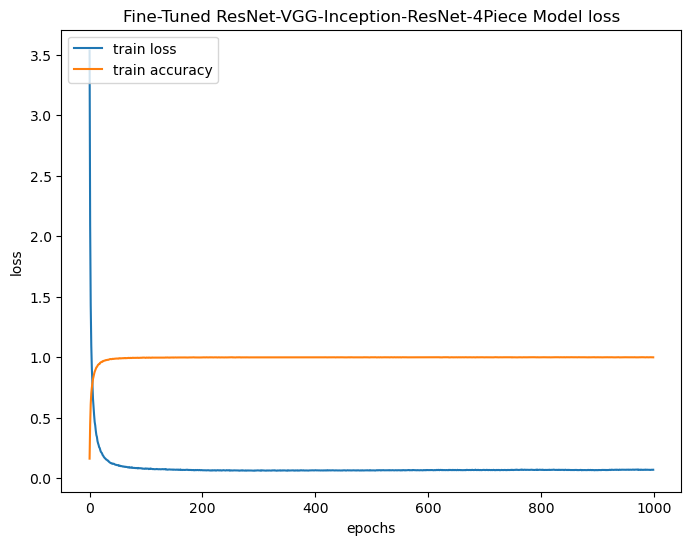

In [32]:
plot_train_loss(history, 'Fine-Tuned ResNet-VGG-Inception-ResNet-4Piece Model')

### Model Evaluation

#### On Train Data

Now, after the model is being trained, we will look at the performance of the model on the training set.

In [33]:
train_preds = model1.predict(fine_tune_data)

 14/500 [..............................] - ETA: 1s  

2022-10-09 18:27:03.953182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 2s 3ms/step


In [34]:
train_pred_labels = np.argmax(train_preds, axis=-1)

In [35]:
train_pred_labels

array([ 1, 13, 13, ...,  3,  9,  9])

In [37]:
np.sum(train_pred_labels == labels['label'])

15997

Looking at the misclassified images to get a better idea about what features the model is unable to capture.

In [39]:
mis_train_data = train_labels[train_pred_labels != labels['label']]
mis_train_data

/var/folders/mg/l90d6s9536n6mfzjbqgrxffm0000gn/T/ipykernel_63013/4074177962.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mis_train_data = train_labels[train_pred_labels != labels['label']]


,id,images,label
3781,3973,./Data/train/train/3973.tif,3
9682,10194,./Data/train/train/10194.tif,4
12896,13576,./Data/train/train/13576.tif,9


In [40]:
precision, recall, fscore, support = score(labels['label'], train_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,1.000000,0.999031,0.999515,1032
1,1.000000,1.000000,1.000000,969
2,1.000000,1.000000,1.000000,968
3,1.000000,1.000000,1.000000,993
4,0.998966,1.000000,0.999483,966
5,1.000000,1.000000,1.000000,1012
6,1.000000,1.000000,1.000000,1044
7,0.997932,1.000000,0.998965,965
8,1.000000,1.000000,1.000000,1059
9,1.000000,0.999000,0.999500,1000


#### On Validation Data

Generating Predictions for the Validation Set

In [29]:
validation_data = pd.DataFrame({'images':['./Data/validation/validation/'+name for name in os.listdir('./Data/validation/validation/')]})
validation_data['id'] = [name.split('.')[0] for name in os.listdir('./Data/validation/validation/')]
validation_data['label'] = -1 # Simply added to prevent re-writing code
validation_data.sort_values(by=['id'], inplace=True)
validation_data

,images,id,label
850,./Data/validation/validation/17801.tif,17801,-1
898,./Data/validation/validation/17802.tif,17802,-1
852,./Data/validation/validation/17803.tif,17803,-1
798,./Data/validation/validation/17804.tif,17804,-1
750,./Data/validation/validation/17805.tif,17805,-1
...,...,...,...
246,./Data/validation/validation/18696.tif,18696,-1
211,./Data/validation/validation/18697.tif,18697,-1
760,./Data/validation/validation/18698.tif,18698,-1
787,./Data/validation/validation/18699.tif,18699,-1


In [30]:
fine_tune_data_validation_resnet = np.load('./Data/ResNet-4P-validation-precompute/whole_validation_data_precomp.npy')
fine_tune_data_validation_resnet.shape

(900, 5, 2048)

In [31]:
fine_tune_data_validation_vgg = np.load('./Data/VGG16-4P-validation-precompute/whole_validation_data_precomp.npy')
fine_tune_data_validation_vgg.shape

(900, 5, 512)

In [32]:
fine_tune_data_validation_inception_resnet = np.load('./Data/Inception-ResNet-4P-validation-precompute/whole_validation_data_precomp.npy')
fine_tune_data_validation_inception_resnet.shape

(900, 5, 1536)

In [33]:
fine_tune_data_validation_red_resnet = np.zeros((fine_tune_data_validation_resnet.shape[0], 5, N_COMPS_1))
for i in range(5):
    fine_tune_data_validation_red_resnet[:,i,:] = pcas_resnet[i].transform(fine_tune_data_validation_resnet[:,i,:])
fine_tune_data_validation_resnet = fine_tune_data_validation_red_resnet
del fine_tune_data_validation_red_resnet
fine_tune_data_validation_resnet.shape

(900, 5, 1300)

In [34]:
fine_tune_data_validation_red_vgg = np.zeros((fine_tune_data_validation_vgg.shape[0], 5, N_COMPS_2))
for i in range(5):
    fine_tune_data_validation_red_vgg[:,i,:] = pcas_vgg[i].transform(fine_tune_data_validation_vgg[:,i,:])
fine_tune_data_validation_vgg = fine_tune_data_validation_red_vgg
del fine_tune_data_validation_red_vgg
fine_tune_data_validation_vgg.shape

(900, 5, 300)

In [35]:
fine_tune_data_validation_red_inception_resnet = np.zeros((fine_tune_data_validation_inception_resnet.shape[0], 5, N_COMPS_3))
for i in range(5):
    fine_tune_data_validation_red_inception_resnet[:,i,:] = pcas_inception_resnet[i].transform(fine_tune_data_validation_inception_resnet[:,i,:])
fine_tune_data_validation_inception_resnet = fine_tune_data_validation_red_inception_resnet
del fine_tune_data_validation_red_inception_resnet
fine_tune_data_validation_inception_resnet.shape

(900, 5, 900)

In [36]:
fine_tune_data_validation = np.concatenate([fine_tune_data_validation_resnet, fine_tune_data_validation_vgg, fine_tune_data_validation_inception_resnet], axis=-1)
fine_tune_data_validation.shape

(900, 5, 2500)

In [37]:
# np.save('./Data/ResNet-VGG-Inception-4Piece-PCA-validation-precompute/whole_validation_data_precomp.npy', fine_tune_data_validation)

In [49]:
valid_preds = model1.predict(fine_tune_data_validation)

14/29 [=============>................] - ETA: 0s

2022-10-09 18:28:13.201710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 8ms/step


In [50]:
valid_pred_labels = np.argmax(valid_preds, axis=-1)

### Submission

For Kaggle Submission

In [51]:
submission_data = pd.DataFrame({'id':list(range(17801, 18701))})
submission_data['label'] = valid_pred_labels
submission_data

,id,label
0,17801,4
1,17802,6
2,17803,4
3,17804,8
4,17805,3
...,...,...
895,18696,7
896,18697,12
897,18698,8
898,18699,3


In [53]:
submission_data.to_csv('./Submissions/submission-resnet-vgg-inception-4p.csv', index=False)